# High-speed delivery robot powertrain design using synthetic driving cycles
The purpose of this study is to dimension the electric powertrain components for a high-speed delivery robot.
The powertrain components of interest are the motor and the battery.

In [1]:
import pandas as pd
import numpy as np
import osmnx as ox
import chaospy
import time
import matplotlib.pyplot as plt
from cycle import make_cycle
from cycle import make_noise
from drive import drive_EV_bw_no_reg, drive_EV_bw_no_reg_max_power

#dataframe
df = pd.read_csv('./data/wolt21.csv')

#Print log (not obligatory)
ox.config(log_console=True)
ox.__version__
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

# Load map
G = ox.load_graphml("./data/wolt_network_walk_elevation.graphml")

#distributions
idle_normal = chaospy.TruncNormal(0, 30, mu=15, sigma=4) #estimated
m_normal = chaospy.TruncNormal(0.5, 8, mu=4, sigma=1.2) #estimated
a_normal = chaospy.TruncNormal(0.5, 2, mu=1, sigma=0.3)
dcc_normal = chaospy.TruncNormal(-2, -0.5, mu=-1, sigma=0.3)
hw_normal = chaospy.TruncNormal(-10, 10, mu=0, sigma=3)
rrc_normal = chaospy.TruncNormal(0, 0.03, mu=0.015, sigma=0.004) #estimated
aux_normal = chaospy.TruncNormal(50, 70, mu=60, sigma=3)

# idle_normal = chaospy.Uniform(0, 30) #estimated
# m_normal = chaospy.Uniform(0.5, 8) #estimated
# a_normal = chaospy.Uniform(0.5, 2)
# dcc_normal = chaospy.Uniform(-2, -0.5)
# hw_normal = chaospy.Uniform(-10, 10)
# rrc_normal = chaospy.Uniform(0, 0.03)
# aux_normal = chaospy.Uniform(50, 70)

#OSMNx calculations
def calculate_route(G, df, id):
    orig = ox.distance.nearest_nodes(G, X=df.USER_LONG.values[id], Y=df.USER_LAT.values[id])
    dest = ox.distance.nearest_nodes(G, X=df.VENUE_LONG.values[id], Y=df.VENUE_LAT.values[id])
    route = ox.shortest_path(G, orig, dest, weight="length")
    # Get the elevations of nodes
    elevations=[]
    for i in range(0, len(route)):
        node_id = list(G.nodes)[i]
        elevations.append(G.nodes[node_id]['elevation'])
    # calculate slopes for edges
    edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
    return edge_lengths, elevations

# Derivate of a signal for keeping track of uphills in a route
def numerical_positive_derivative(data):
    dy = np.zeros(len(data))
    dy[0:-1] = np.diff(data)/np.diff(t_data)
    for i in range(0,len(dy)):
        if dy[i] < 0:
            dy[i]=0
    return np.cumsum(dy)[-1]

# Progress Bar for Monte Carlo Simulations
def progress_bar(current, total, start_time, current_time, bar_length = 30):
    runtime = round(current_time - start_time, 2)
    loop = round(runtime / (current + 1),2)
    eta = round((loop * (total - current))/60,2)
    percent = float(current) * 100 / total
    arrow   = '-' * int(percent/100 * bar_length - 1) + '>'
    spaces  = ' ' * (bar_length - len(arrow))

    print('Progress: [%s%s] %d %%' % (arrow, spaces, percent) + "  runtime: %s s, loop: %s s, eta: %s min" % (runtime, loop, eta), end='\r')

## 1. Size and shape
Here, a differential wheeled robot with two driving wheels with hub motors, which translates to inexpensive and robust design.
A third smaller wheel is a free turning wheel.
The large front wheels allow the robot to travel in uneven terrain and climb sidewalk curbs.
The maximum speed of the vehicle is set to 15 km/h so that it is within U.S. and Finnish regulations.
The robot including its body, electronics, wheels, motors and battery is estimated to weight 16 kg.
Based on the design, the frontal area is approximately 0.2 $m^2$ and the coefficient of drag 0.6.

## 2. Motor selection
In order to select a battery, the voltage level of the motor has to be determined by the designer.
In a small vehicle such as a SADR, low voltage level such as 24, 36 or 48 V is preferred, which reduces the risk of serious electric shocks.
In the worst-case scenario, the robot is accelerating to its maximum speed
to an uphill, with its maximum load, headwind, and with snow that increases the rolling resistance coefficient.
The robot dynamics are calculated with
\begin{equation}
    \sum F=F_{ma}+F_{rr}+F_{drag}
\end{equation}
\begin{equation}
    F_{ma} = ma
\end{equation}
\begin{equation}
    F_{drag} = \frac{1}{2}C_dA \rho v^2
\end{equation}
\begin{equation}
    F_{rr} = (\mu + \sin{\theta})mg
\end{equation}

In the equations above, $F_{ma}, F_{drag}, F_{rr}$ are the resistive forces of movement, namely accelerative, drag, rolling resistance and slope, respectively.
Mass in denoted as $m$, acceleration as $a$, velocity as $v$, coefficient of drag as $C_d$, rolling resistance coefficient as $\mu$, frontal area as $A$, density of air as $\rho$, slope in degrees as $\theta$ and the gravitational acceleration as $g$.

A backward-facing model has been built abiding to these equations in the drive.py file. Next, worst-case scenario analysis is carried out with the model to dimension the motor

Motors of the robot should be able to provide 519.0 W of power. (Aux not considered!)
Motors accelerating the robot 2m/s^2 on flat ground should be able to provide 347.0 W of power. (Aux not considered!)


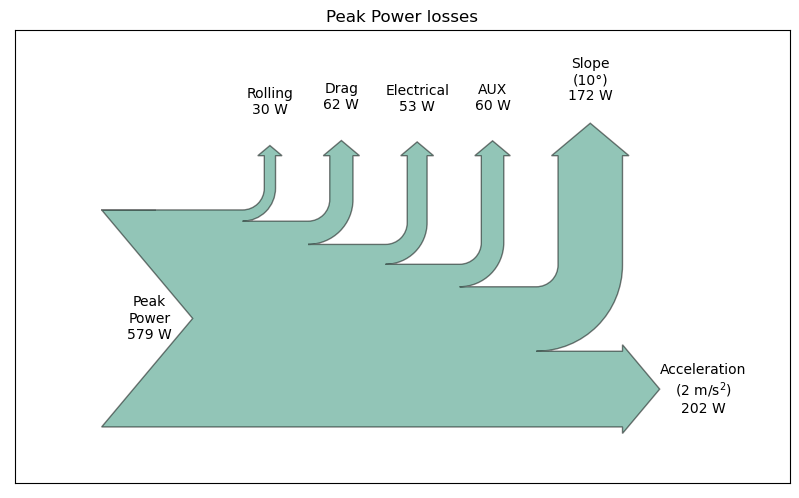

In [2]:
# Worst-case conditions
hw = 10 # worst case headwind (m/s)
v_max = 15/3.6 # max speed (m/s)
a_max = 2 # max acceleration (m/s^2)
grade=10*((2*np.pi)/360) # max uphill slope (10 deg)
rrc = 0.03 # max rolling resistance coefficient (-)
m_package = 8 # max payload (kg)

t_data, v_data, P_data, F_d_data, F_grade_data, F_ma_data, F_rr_data, aux, eff_loss, energy = drive_EV_bw_no_reg_max_power(v_max,a_max, hw, grade, rrc, m_package, m_bot_bat=15+1)

# Power data
ip = np.argmax(P_data)
P_max=np.max(P_data)
P_causes = [F_ma_data[ip]*v_data[ip], F_d_data[ip]*v_data[ip], F_grade_data[ip]*v_data[ip], F_rr_data[ip]*v_data[ip], aux]

causes = ['Peak\nPower',  'Rolling', 'Drag', 'Electrical', 'AUX','Slope\n(10'+chr(176)+')', 'Acceleration\n(2 m/s$^2$)']

from matplotlib.sankey import Sankey

flows=[P_data[ip], -F_rr_data[ip]*v_data[ip], -F_d_data[ip]*v_data[ip], -eff_loss[ip], -aux, -F_grade_data[ip]*v_data[ip], -F_ma_data[ip]*v_data[ip]]
perce_flows=[]
for flow in flows:
    #perce_flows.append(round(flow/P_data[ip],2))
    perce_flows.append(round(flow,0))

# basic sankey chart
Sankey(flows=perce_flows, scale=1/P_data[ip], unit=" W", labels=causes, offset=0.2, facecolor='#278D70', alpha=0.5, orientations=[0, 1, 1, 1, 1, 1, 0]).finish()
plt.title("Peak Power losses")

# Conclusion:
print('Motors of the robot should be able to provide '+str(round(P_max-aux,0))+' W of power. (Aux not considered!)')
print('Motors accelerating the robot '+str(a_max)+ 'm/s^2 on flat ground should be able to provide '+str(round(P_max-aux-F_grade_data[ip]*v_data[ip],0))+' W of power. (Aux not considered!)')

## 3. Minimum battery size
The battery selection is depended on the motor voltage and maximum power, as they determine the maximum C-rate in use.
In addition, as a secondary condition the charging C-rate should be considered.
The charging power depends on the rate of charging, whether it is fast or slow charging.
The capacity of the battery is determine by the choice of opportunity or overnight charging.
In opportunity charging, the battery is fast charged at public chargers placed inside vendors or out in the street, whenever an opportunity arises.
In overnight charging, the battery is slow charged at same places as for opportunity charging or at a robot depot at the end of the day, during the night.
The available battery capacity $Q_{ah}$ and $C_{rate}$ of the battery can be computed with
\begin{equation}
    Q_{ah} = 0.8Q_{ah,real}U_{bat}
\end{equation}
\begin{equation}
    C_{rate} = \frac{P_{max}}{Q_{ah}U_{bat}}
\end{equation}

where $Q_{ah,real}$ is the battery capacity (in ampere-hours) reported in the datasheet, $U_{bat}$ is battery nominal voltage and $P_{max}$ is the maximum power of the motor.
It is important to note that the battery should not discharged under 20 \% SoC **(State-of-Charge)**, for safety and longevity of the battery use.
Therefore, only 80 \% of the battery capacity can be used and the battery has to be able to provide sufficient power even at 20 \% SoC.
The maximum power of the motor can be replaced by the power of charging to determine the C-rates of slow and fast charging.
The battery design begins by selecting the smallest capacity battery possible because battery price is the most common economic feasibility issue of electric powertrains.
After the minimum battery selection, operation of the robot is investigated with Monte Carlo simulations to determine the need for a larger battery.

Minimum battery: ZIPPY Compact 4500mAh 10S 35C Lipo Pack w/ XT90
https://hobbyking.com/en_us/zippy-compact-4500mah-10s-35c-lipo-pack-xt90.html

In [3]:
#ZIPPY Compact 4500mAh 10S 35C Lipo Pack
ah=4.5 # battery capacity (Ah)
m_bat=1.13 # battery weight (kg)
V = 37 # battery voltage (V)
V20= 34 # battery voltage (V) at 20% (approximately)
bat_capa=ah*V*0.8 # Should not operate below 20 % SoC (Ah)
bat_e_dens=bat_capa/m_bat # battery energy density (Wh/kg)
bat_price = 98 # battery price (in euros)

print('Battery weight is ' + str(m_bat) + 'kg')
print('Battery capacity is '+str(int(bat_capa))+' Wh, energy density is '+str(int(bat_e_dens))+' Wh/kg and price is '+str(int(1000*bat_price/(bat_capa)))+' €/kWh. (' + str(bat_price) + ' €)')
print('Slow charge (500 W) time of the battery is '+str(int(bat_capa/(500/60)))+' minutes. Slow charge C-rate: '+str(round((500/V)/ah,1)))
print('Fast charge (2 kW) time of the battery is '+str(int(bat_capa/(2000/60)))+' minutes. Fast charge C-rate: '+str(round((2000/V)/ah,1)))

i_max = P_max/V20
C_rate = i_max/ah
print('Max current is '+str(round(i_max,1))+' A with a '+str(V)+' V battery, which results in C-rate of '+str(round(C_rate,1))+' when the SoC is 20 %.')

Battery weight is 1.13kg
Battery capacity is 133 Wh, energy density is 117 Wh/kg and price is 735 €/kWh. (98 €)
Slow charge (500 W) time of the battery is 15 minutes. Slow charge C-rate: 3.0
Fast charge (2 kW) time of the battery is 3 minutes. Fast charge C-rate: 12.0
Max current is 17.0 A with a 37 V battery, which results in C-rate of 3.8 when the SoC is 20 %.


## 4. Monte Carlo Simulations

In the Monte Carlo simulations, synthetic operation cycles were generated based on delivery data acquired by Wolt.
These 18,500 deliveries were recorded in Helsinki, Finland, from August to September 2020.
Open Street map is utilized with the Python library OSMnx to determine the shortest routes for pedestrians from one location to another.
The map consists of edges and nodes.
The synthetic cycles are generated by getting the pedestrian route from OSMnx by giving the user and vendor locations as inputs.
OSMnx returns a list of edges.

### 4.1 Synthetic cycles
Simulated stops are added to the route with the probability of 10 \% for each node as it result with a estimated realistic amount of stops per kilometer.
If no stop occurs, the length of two edges are added together.
On each of the edges the robot is given one third of the edge length for acceleration.
It tries to reach its maximum speed but will settle for a lower speed if there is no time to do it.
Furthermore, idle time is added after the stop.
The acceleration, deceleration and idle values are drawn from truncated Gaussian distributions.
In addition, the mass, headwind, rolling resistance coefficient and auxiliary power is also uncertain with Gaussian noise.

To add inconsistency to the synthetic cycles, autocorrelated noise and moving-average methods are used in tandem.
Autocorrelated noise has high correlatation with the previous value and low noise.
Moving average is used to smoothen the noise to make it less erratic.
The following figures show examples of the normal sythetic cycles and with added noise.

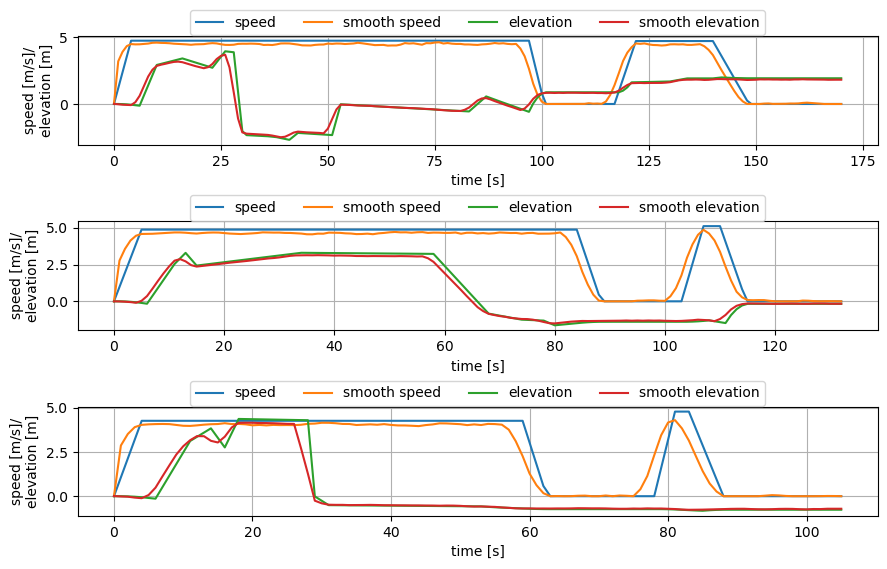

In [4]:
# Samples of the synthetic cycles

def plt_cycle(t_data, v_data, v_data_noise, ele_data, ele_data_noise, i):
    plt.subplot(3, 1, i)
    plt.grid()
    plt.plot(t_data, v_data)
    plt.plot(t_data, v_data_noise)
    plt.plot(t_data, ele_data)
    plt.plot(t_data, ele_data_noise)
    plt.xlabel('time [s]')
    plt.ylabel('speed [m/s]/\nelevation [m]')
    plt.legend(['speed', 'smooth speed', 'elevation', 'smooth elevation'], loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=4)

for ix in range(0,3):
    edges, elevations = calculate_route(G, df, ix+90)
    #print('Distance of original edges was: ' + str(round(sum(edges)/1000, 2)) + ' km')
    if sum(edges) > 0:
        t_data, v_data, ele_data, diff, stps, a_mu, dcc_mu = make_cycle(edges, elevations, idle_normal, a_normal, dcc_normal, 15)

        hw=hw_normal.sample(1)[0]
        rrc=rrc_normal.sample(1)[0]
        m=m_normal.sample(1)[0]
        aux=aux_normal.sample(1)[0]
        energy = drive_EV_bw_no_reg(t_data, v_data, ele_data, hw, rrc, m, aux)
        distance = sum(edges)

        v_data_noise = make_noise(v_data, sigma=0.1, ma_window=4)
        ele_data_noise = make_noise(ele_data, sigma=0.02, ma_window=3)
        plt_cycle(t_data, v_data, v_data_noise, ele_data, ele_data_noise, ix+1)
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.7)

### 4.2 Case: Minimum battery
First, the Monte Carlo simulations are run with the minimum battery that is light-weight but has also very limited capacity.

In [5]:
#variables
t_final_data=[]
stps_data=[]
spk_data=[]
a_mu_data=[]
dcc_mu_data=[]
hw_data=[]
rrc_data=[]
m_data=[]
distance_data=[]
aux_data=[]
ele_sum=[]
uphill=[]
energy_data=[]
epk_data=[]
time_slow=[]
energy_data_slow=[]
epk_data_slow=[]

rng = np.random.default_rng()
# Drive ALL the cycles (MCS)
# for ix in range(0, 18700):
#     edges = calculate_route(G, df, ix)

start_time = time.time()
SPEED_KMH = 15
RUNS = 5000
for ix in range(0, RUNS):
    edges, elevations = calculate_route(G, df, int(rng.random()*18700)) #PICK A RANDOM ROUTE OF ALL OF THE AVAILABLE ONES

    #print('Distance of original edges was: ' + str(round(sum(edges)/1000, 2)) + ' km')
    if sum(edges) > 0:
        t_data, v_data, ele_data, diff, stps, a_mu, dcc_mu = make_cycle(edges, elevations, idle_normal, a_normal, dcc_normal, SPEED_KMH)

        v_data = make_noise(v_data, sigma=0.1, ma_window=4)
        ele_data = make_noise(ele_data, sigma=0.02, ma_window=3)

        hw=hw_normal.sample(1)[0]
        rrc=rrc_normal.sample(1)[0]
        m=m_normal.sample(1)[0]
        aux=aux_normal.sample(1)[0]
        energy = drive_EV_bw_no_reg(t_data, v_data, ele_data, hw, rrc, m, aux)
        distance = sum(edges)

        # Saving data
        t_final_data.append(t_data[-1])
        stps_data.append(stps)
        spk_data.append(stps/(distance/1000))
        a_mu_data.append(a_mu)
        dcc_mu_data.append(dcc_mu)
        hw_data.append(hw)
        rrc_data.append(rrc)
        m_data.append(m)
        distance_data.append(distance)
        aux_data.append(aux)
        uphill.append(numerical_positive_derivative(ele_data))
        ele_sum.append(ele_data[-1])
        energy_data.append(energy)
        epk_data.append(energy/(distance/1000))

        t_data, v_data, ele_data, diff, stps, a_mu, dcc_mu  = make_cycle(edges, elevations, idle_normal, a_normal, dcc_normal, 6)
        energy=drive_EV_bw_no_reg(t_data, v_data, ele_data, hw, rrc, m, aux)
        energy_data_slow.append(energy)
        epk_data_slow.append(energy/(distance/1000))
        time_slow.append(t_data[-1])

        progress_bar(ix, RUNS, start_time, time.time())


d={'t':t_final_data,
    'stps':stps_data,
    'spk':spk_data,
    'a_mu':a_mu_data,
    'dcc_mu':dcc_mu_data,
    'hw':hw_data,
    'rrc':rrc_data,
    'm':m_data,
    'd':distance_data,
    'aux':aux_data,
    'uphill':uphill,
    'ele':ele_sum,
    'e':energy_data,
    'epk':epk_data,
    'e_slow':energy_data_slow,
    'epk_slow':epk_data_slow,
    'time_slow':time_slow}

df_results=pd.DataFrame(data=d)
df_results.to_csv('./data/d-bot_sim_'+str(df_results.shape[0])+'routes_1kgbattery_uniform.csv', index=False)

IndexError: list index out of range

In [5]:
import math
df_high = pd.read_csv('./data/d-bot_sim_4997routes_1kgbattery.csv')

trips = math.floor(bat_capa/round(np.mean(df_high.e.values),2))
time_spent = round(np.mean(df_high.t.values)/60,2)
energy_route = round(np.mean(df_high.e.values),2)
energy_km = round(np.mean(df_high.epk.values),2)
d_bot_1kg=[time_spent*trips/60, bat_capa, (energy_route/energy_km)*trips, 60, 16, 0.5 ,15]

# Creating distributions
epk_1kg_kernel = chaospy.GaussianKDE(df_high.epk.values)
e_1kg_kernel = chaospy.GaussianKDE(df_high.e.values)
epk_1kg_slow_kernel = chaospy.GaussianKDE(df_high.epk_slow.values)
e_1kg_slow_kernel = chaospy.GaussianKDE(df_high.e_slow.values)

print('EoT: ' + str(energy_km) + ' Wh/km')
print('Energy spent per trip is on average ' + str(energy_route) +' Wh.')
print('Time spent per trip is on average ' + str(time_spent) +' min. \n')
#trips = math.floor(bat_capa/round(np.mean(df_high.e.values),2))
#time_spent = round(np.mean(df_high.t.values)/60,2)
print('There is enough energy in one battery for ' + str(trips) + ' trips, which means driving time of ' +str(round((time_spent*trips)/60,2)) +  ' h and a range of '
    + str(round((energy_route/energy_km)*trips,2)) + ' km.')

trips = math.floor(bat_capa/round(np.mean(df_high.e_slow.values),2))
time_spent = round(np.mean(df_high.time_slow.values)/60,2)
energy_route = round(np.mean(df_high.e_slow.values),2)
energy_km = round(np.mean(df_high.epk_slow.values),2)
d_bot_1kg_slow=[time_spent*trips/60, bat_capa, (energy_route/energy_km)*trips, 60, 16, 0.5, 6]

EoT: 6.53 Wh/km
Energy spent per trip is on average 8.43 Wh.
Time spent per trip is on average 5.78 min. 

There is enough energy in one battery for 15 trips, which means driving time of 1.44 h and a range of 19.36 km.


#### 4.2.2 Case: Full-day battery
With the minimal battery, there is enough energy for operation of ~18 trips that take approximately ~100 minutes.
However, there is time and energy spent from getting from a previous destination to new starting point, which reduces the actual energy spent for missions.
The slow charging of such a battery is 15 minutes, so the down time is not too bad, because there are no orders all the time.
Fast charging is also a possibility, with a charge of only 3 minutes.
However, the minimal battery requires chargers installed in many places, possibly on the street or in restaturants or next to postal lockers.

Next, we wil consider a case where the battery capacity is large enough for the robot to operate all day and only charged during the night time.
Operation time of 12 hours is estimated to suffice for the full-day operation with one charge.
Based on the previous calculations, 8 of the batteries in the minimal battery case are added in parallel.
This increase significantly the battery capacity, but also the battery weight.

In [6]:
#8 pcs of ZIPPY Compact 4500mAh 10S 35C Lipo Pack 
ah=4.5*8
m_bat=1.13*8
V = 37 # Battery voltage
V20= 34 # Battery voltage at 20% (approximately)
bat_capa=ah*V*0.8 # Should not operate below 20 % SoC
bat_e_dens=bat_capa/m_bat #Wh/kg
bat_price = 98*8 #euros
P_max=680 #W, with the added weight

print('Battery weight is ' + str(m_bat) + 'kg')
print('Battery capacity is '+str(int(bat_capa))+' Wh, energy density is '+str(int(bat_e_dens))+' Wh/kg and price is '+str(int(1000*bat_price/(bat_capa)))+' €/kWh. (' + str(bat_price) + ' €)')
print('Slow charge (500 W) time of the battery is '+str(int(bat_capa/(500/60)))+' minutes. Slow charge C-rate: '+str(round((500/V)/ah,1)))
print('Fast charge (2 kW) time of the battery is '+str(int(bat_capa/(2000/60)))+' minutes. Fast charge C-rate: '+str(round((2000/V)/ah,1)))

i_max = P_max/V20
C_rate = i_max/ah
print('Max current is '+str(round(i_max,1))+' A with a '+str(V)+' V battery, which results in C-rate of '+str(round(C_rate,1))+' when the SoC is 20 %.')

Battery weight is 9.04kg
Battery capacity is 1065 Wh, energy density is 117 Wh/kg and price is 735 €/kWh. (784 €)
Slow charge (500 W) time of the battery is 127 minutes. Slow charge C-rate: 0.4
Fast charge (2 kW) time of the battery is 31 minutes. Fast charge C-rate: 1.5
Max current is 20.0 A with a 37 V battery, which results in C-rate of 0.6 when the SoC is 20 %.


In [4]:
#variables
t_final_data=[]
stps_data=[]
spk_data=[]
a_mu_data=[]
dcc_mu_data=[]
hw_data=[]
rrc_data=[]
m_data=[]
distance_data=[]
aux_data=[]
uphill=[]
ele_sum=[]
energy_data=[]
epk_data=[]
time_slow=[]
energy_data_slow=[]
epk_data_slow=[]

rng = np.random.default_rng()
# Drive ALL the cycles (MCS)
# total of 18700
#for ix in range(0, 18700):
#    edges = calculate_route(G, df, ix)
start_time = time.time()
SPEED_KMH = 15
RUNS = 18000
for ix in range(0, RUNS):
    edges, elevations = calculate_route(G, df, ix) #PICK A RANDOM ROUTE OF ALL OF THE AVAILABLE ONES
    if sum(edges) > 0:
        t_data, v_data, ele_data, diff, stps, a_mu, dcc_mu = make_cycle(edges, elevations, idle_normal, a_normal, dcc_normal, SPEED_KMH)

        v_data = make_noise(v_data, sigma=0.1, ma_window=4)
        ele_data = make_noise(ele_data, sigma=0.02, ma_window=3)

        hw=hw_normal.sample(1)[0]
        rrc=rrc_normal.sample(1)[0]
        m=m_normal.sample(1)[0]
        aux=aux_normal.sample(1)[0]
        energy = drive_EV_bw_no_reg(t_data, v_data, ele_data, hw, rrc, m, aux, m_bot_bat=15+9)
        distance = sum(edges)

        # Saving data
        t_final_data.append(t_data[-1])
        stps_data.append(stps)
        spk_data.append(stps/(distance/1000))
        a_mu_data.append(a_mu)
        dcc_mu_data.append(dcc_mu)
        hw_data.append(hw)
        rrc_data.append(rrc)
        m_data.append(m)
        distance_data.append(distance)
        aux_data.append(aux)
        uphill.append(numerical_positive_derivative(ele_data))
        ele_sum.append(ele_data[-1])
        energy_data.append(energy)
        epk_data.append(energy/(distance/1000))

        t_data, v_data, ele_data, diff, stps, a_mu, dcc_mu  = make_cycle(edges, elevations, idle_normal, a_normal, dcc_normal, 6)
        energy=drive_EV_bw_no_reg(t_data, v_data, ele_data, hw, rrc, m, aux, m_bot_bat=15+9)
        energy_data_slow.append(energy)
        epk_data_slow.append(energy/(distance/1000))
        time_slow.append(t_data[-1])

        progress_bar(ix, RUNS, start_time, time.time())


d={'t':t_final_data,
    'stps':stps_data,
    'spk':spk_data,
    'a_mu':a_mu_data,
    'dcc_mu':dcc_mu_data,
    'hw':hw_data,
    'rrc':rrc_data,
    'm':m_data,
    'd':distance_data,
    'aux':aux_data,
    'uphill':uphill,
    'ele':ele_sum,
    'e':energy_data,
    'epk':epk_data,
    'e_slow':energy_data_slow,
    'epk_slow':epk_data_slow,
    'time_slow':time_slow}
    
df_results2=pd.DataFrame(data=d)
df_results2.to_csv('./data/d-bot_sim_'+str(df_results2.shape[0])+'routes_9kgbattery_uniform.csv', index=False)

In [7]:
import math
df_high = pd.read_csv('./data/d-bot_sim_4995routes_9kgbattery.csv')

trips = math.floor(bat_capa/round(np.mean(df_high.e.values),2))
time_spent = round(np.mean(df_high.t.values)/60,2)
energy_route = round(np.mean(df_high.e.values),2)
energy_km = round(np.mean(df_high.epk.values),2)
d_bot_9kg=[time_spent*trips/60, bat_capa, (energy_route/energy_km)*trips, 60, 24, (np.mean(df_high.d.values)/np.mean(df_high.t.values)), 0.33]

# Creating distributions
epk_9kg_kernel = chaospy.GaussianKDE(df_high.epk.values)
e_9kg_kernel = chaospy.GaussianKDE(df_high.e.values)
epk_9kg_slow_kernel = chaospy.GaussianKDE(df_high.epk_slow.values)
e_9kg_slow_kernel = chaospy.GaussianKDE(df_high.e_slow.values)

print('EoT: ' + str(energy_km) + ' Wh/km')
print('Energy spent per trip is on average ' + str(energy_route) +' Wh.')
print('Time spent per trip is on average ' + str(time_spent) +' min. \n')
trips = math.floor(bat_capa/round(np.mean(df_high.e.values),2))
time_spent = round(np.mean(df_high.t.values)/60,2)
print('There is enough energy in one battery for ' + str(trips) + ' trips, which means driving time of ' +str(round((time_spent*trips)/60,2)) +  ' h and a range of '
    + str(round((energy_route/energy_km)*trips,2)) + ' km.')

trips = math.floor(bat_capa/round(np.mean(df_high.e_slow.values),2))
time_spent = round(np.mean(df_high.time_slow.values)/60,2)
energy_route = round(np.mean(df_high.e_slow.values),2)
energy_km = round(np.mean(df_high.epk_slow.values),2)
d_bot_9kg_slow=[time_spent*trips/60, bat_capa, (energy_route/energy_km)*trips, 60, 34, (6/3.6) * (3.6*np.mean(df_high.d.values)/np.mean(df_high.t.values))/15, 0.33]

EoT: 7.06 Wh/km
Energy spent per trip is on average 9.22 Wh.
Time spent per trip is on average 5.82 min. 

There is enough energy in one battery for 115 trips, which means driving time of 11.16 h and a range of 150.18 km.


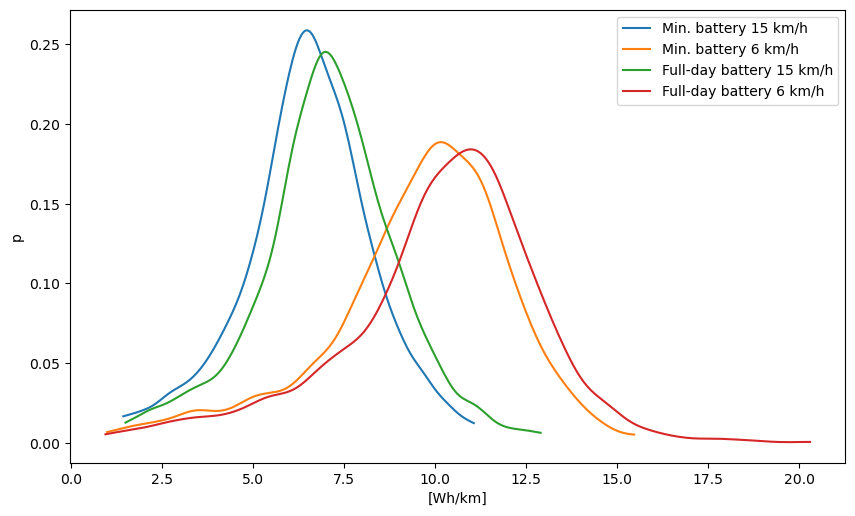

In [8]:
## Plotting 1kg vs. 9kg battery
# Creating distributions
def plt_dist(dist):
    sample = dist.sample(200)
    q_loc = np.linspace(min(sample), max(sample), 200)
    plt.grid()
    plt.plot(q_loc, dist.pdf(q_loc))

dists = [epk_1kg_kernel, epk_1kg_slow_kernel, epk_9kg_kernel, epk_9kg_slow_kernel]

i=0
for dist in dists:
    plt_dist(dist)
    i=i+1
plt.xlabel('[Wh/km]')
plt.ylabel('p')
plt.legend(['Min. battery 15 km/h', 'Min. battery 6 km/h', 'Full-day battery 15 km/h', 'Full-day battery 6 km/h'])

## Energy demand analysis
Where is the energy spent during operation?

In [12]:
from drive import drive_EV_bw_no_reg_power_dist
rng = np.random.default_rng()
start_time = time.time()
SPEED_KMH = 15
RUNS = 5000
energies=np.zeros((RUNS,8))
for ix in range(0, RUNS):
    edges, elevations = calculate_route(G, df, int(rng.random()*18700)) #PICK A RANDOM ROUTE OF ALL OF THE AVAILABLE ONES
    if sum(edges) > 0:
        t_data, v_data, ele_data, diff, stps, a_mu, dcc_mu = make_cycle(edges, elevations, idle_normal, a_normal, dcc_normal, SPEED_KMH)

        v_data = make_noise(v_data, sigma=0.1, ma_window=4)
        ele_data = make_noise(ele_data, sigma=0.02, ma_window=3)

        hw=hw_normal.sample(1)[0]
        rrc=rrc_normal.sample(1)[0]
        m=m_normal.sample(1)[0]
        aux=aux_normal.sample(1)[0]
        energies[ix] = drive_EV_bw_no_reg_power_dist(t_data, v_data, ele_data, hw, rrc, m, aux, m_bot_bat=15+9)

        progress_bar(ix, RUNS, start_time, time.time())


df_power = pd.DataFrame(data=energies, columns=["total", "drag", "rrc", "slope", "accel.", "aux", "mot. loss", "bat. loss"])
df_power.to_csv('./data/d-bot_sim_'+str(df_power.shape[0])+'routes_9kgbattery_power_dist.csv', index=False)

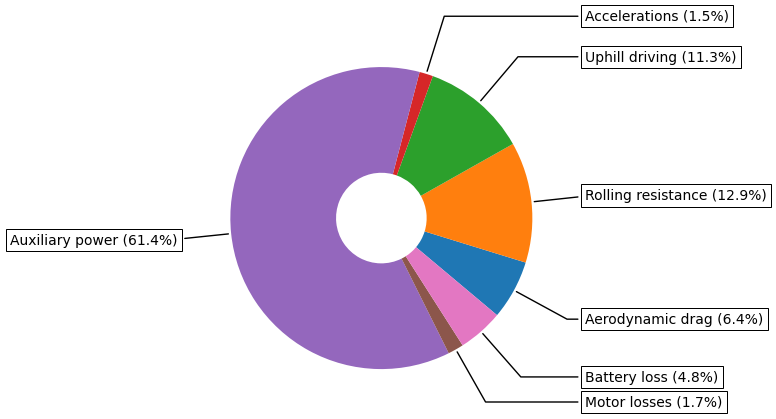

In [9]:
df_power = pd.read_csv('./data/d-bot_sim_5000routes_9kgbattery_power_dist.csv')
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(aspect="equal"))

labels = ["Aerodynamic drag", "Rolling resistance", "Uphill driving", "Accelerations", "Auxiliary power", "Motor losses", "Battery loss"]

data = np.mean(df_power[df_power.columns[1::]].values, axis=0)

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.7), startangle=-40)


for i in range(len(labels)):
        labels[i] = labels[i] + " (" + str(round(100*data[i]/sum(data),1)) + "%)"

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

plt.show()

# Energy Demand Sensitivity Analysis
What is the energy demand sensitive to?

Sum first-order of sensitivity indices: 0.91


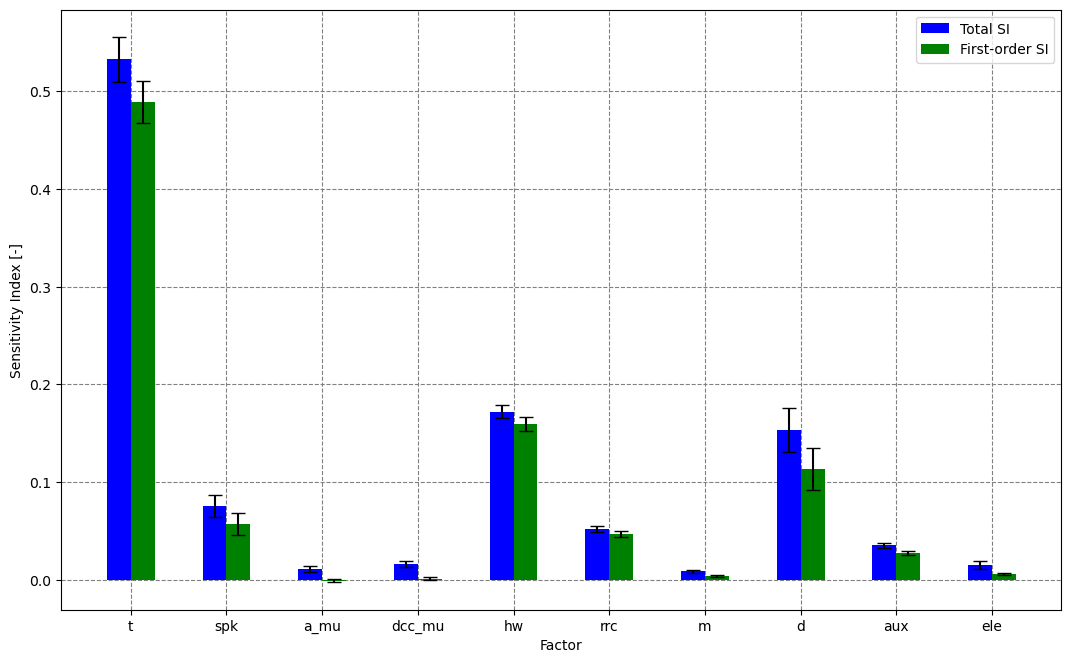

In [11]:
import globalSensitivityAnalysis

df_results = pd.read_csv('./data/d-bot_sim_17981routes_9kgbattery_uniform.csv')

Y = df_results.loc[:, ['epk']]
X = df_results.loc[: ,['t','spk','a_mu','dcc_mu','hw','rrc','m','d','aux','ele']]

df = globalSensitivityAnalysis.gsa_hdmr(X,Y)
S1 = globalSensitivityAnalysis.plot_hdmr(df, X)
print('Sum first-order of sensitivity indices: ' + str(round(sum(S1),2)))

## Cost of Transport
There are no published works or metrics of wheeled robots (such as Kiwi, Starship and Scout, except for their speed and weight.
Starship has some unofficial data which is used here as an estimated benchmark.
Since they are miniature electric vehicles, their cost of transport (CoT) should resemble that of a car.
Multiple quadruped robots are also considered in the comparison, since they could be potentially used for deliveries as well with the capability to travel in difficult terrain and stairs.
Few Quadruped animals (German Shepherd, cheetah and horse) are considered in the analysis as comparison for what biological systems are capable of.
CoT is a unitless metric that only takes into account the energy required for locomotion.
It is used here to compare the energy efficiency of biological and robotic systems.
CoT is defined as 

\begin{equation}
    CoT = \frac{P[W]}{M[kg] \times g[m/s^2] \times v[m/s]}
\end{equation}

where the ratio of the total energy consumption $E$ for a travel of a distance $d$ regarding the gravitational force (Mass $M$ times gravitational acceleration $g$) or by the input power $P$ divided by constant velocity $v$ \cite{tucker1975}.
It is important to note that only the energy or input power used for locomotion is accounted for.
This means that the lower the CoT, the higher the locomotion energy efficiency.
For example, running is less efficient than walking, since a human of 70 kg  walks at 0.38 CoT (1.75 m/s) and jogs (3.75 m/s) with 0.47 CoT \cite{tucker1975}.

\begin{equation}
    EoT = \frac{E[Wh]}{d[km]}
\end{equation}

In [ ]:
def stats(maxHours, batCapacity, maxRange, auxPower, m, maxSpeed, payloadRatio):
    energy_per_km = batCapacity/maxRange
    power_of_travel = (batCapacity - (auxPower*maxHours))/maxHours # W, average power.
    cot = power_of_travel / (m*9.81*maxSpeed)
    energy_per_km_loaded = ((m+(m*payloadRatio))*9.81*cot)/3.6 + auxPower/(maxSpeed*3.6)
    eod = energy_per_km_loaded / (m*payloadRatio)
    return [energy_per_km, energy_per_km_loaded, cot, eod]

def statsFromCot(cot,m,auxPower,maxSpeedKmh, payloadRatio):
    energy_per_km = (m*9.81*cot)/3.6 + auxPower/maxSpeedKmh
    energy_per_km_loaded = ((m+(m*payloadRatio))*9.81*cot)/3.6 + auxPower/maxSpeedKmh
    eod = energy_per_km_loaded / (m*payloadRatio)
    return [energy_per_km, energy_per_km_loaded, cot, eod]
    
starship= stats(2, 148*0.8, 6, 50, 23, 3/3.6, 0.44) # wh/km - aux power. 50 W aux estimate. Speed is set 3km/h because the range of the vehicle was reported with it.
spot=stats(1.5, 605*0.8, 8.6, 200, 32.5, 5.8/3.6, 0.43) # wh/km - aux power. 200 W aux (standby time 180 min so 605 Wh/3h). Average speed of 2.5 km/h
cheetah=statsFromCot(0.45, 45, 200, 9, 0.47)
titan=statsFromCot(1.76, 5.2, 50, 5, 0.96)
anymal=statsFromCot(1.2, 30, 200, 5.4, 0.33)
alphred=statsFromCot(2.6, 18, 100, 5.4, 0.17)
alphred_caster=statsFromCot(0.55, 18, 100, 7.6, 0.17)
bigdog=statsFromCot(5.7, 109, 500, 7.2, 1.41)
#d_bot1 = stats(*d_bot_1kg)
#d_bot1_slow = stats(*d_bot_1kg_slow)
d_bot9 = stats(*d_bot_9kg)
d_bot9_slow = stats(*d_bot_9kg_slow)

names=['Starship', 'Spot', 'D-bot_9kg', 'D-bot_9kg_slow','cheetah',
    'titan', 'anymal', 'alphred', 'alphred_caster', 'bigdog']
things = [starship, spot, d_bot9, d_bot9_slow, cheetah, titan, anymal, alphred, alphred_caster, bigdog]

def printer(name, epk, epk_load, cot, eod, g):
    print('EoT of ' + name + ' was ' + str(round(epk,1)) + ' Wh/km, \tloaded EoT: ' + str(round(epk_load,1)) + ' Wh/km, \tCoT: ' + str(round(cot,3)) + ', \tEoD: ' + str(round(eod,1)) + 'Wh/(kg/km), \tpollution: ' + str(round(eod*g,1)) + ' g/(kg/km).')

i=0
for i in range(0, len(names)):
    # Carbon (g) per kilogram is:
    gElectricity=0.3
    gGasoline=2.75
    g=gElectricity
    if names[i]=="bigdog":
        g=gGasoline
    printer(names[i], things[i][0], things[i][1], things[i][2], things[i][3], g)